# Exploratory work on Siamese convolutional networks for miniproject 1

### What is a siamese network?
A network that has two identical datapaths through weight sharing.

### Importing libs

In [26]:
import torch
from torch import nn as nn
from torch import functional as F
from matplotlib import pyplot as plt
import pandas as pd
import DL_project_utils as utils
import dlc_practical_prologue as prologue

%load_ext autoreload
%autoreload 1
%aimport DL_project_utils

### Defining the model

In [6]:
a,b,c,d,e,f = prologue.generate_pair_sets(1)

TypeError: scatter() received an invalid combination of arguments - got (), but expected one of:
 * (name dim, Tensor index, Tensor src)
 * (int dim, Tensor index, Tensor src)
 * (name dim, Tensor index, Number value)
 * (int dim, Tensor index, Number value)


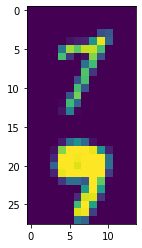

In [18]:
a.size()
plt.imshow(torch.cat((a[0,0,:,:],(a[0,1,:,:])), 0))

100

In [145]:
class SiameseNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=(2,2)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=(2,2)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Flatten(),
            nn.Linear(in_features=800, out_features=70),
            nn.ReLU(),
            nn.Linear(in_features=70, out_features=10),
            nn.Softmax(dim=1)
        )
        self.comparator = nn.Sequential(
            nn.Linear(in_features=20, out_features=2),
            nn.Sigmoid()
        )


    def forward(self, x):
        num_1 = x[:,0,:,:].unsqueeze(1)
        num_2 = x[:,1,:,:].unsqueeze(1)

        pred_1 = self.shared_model(num_1)
        pred_2 = self.shared_model(num_2)

        return self.comparator(torch.cat((pred_1, pred_2), 1))

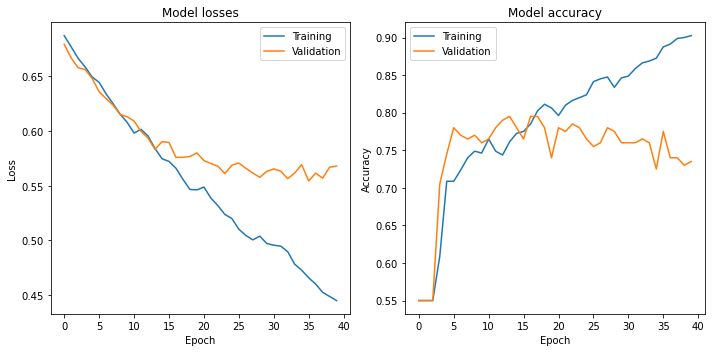

In [146]:
train_data, test_data = utils.read_input(100, single_channel=False)

epochs, lr, loss, optimizer, batch_size = 40, 5e-3, 'cross_entropy', 'Adam', 100
model = SiameseNet1()
train_loss, train_acc, val_loss, val_acc = utils.train_model(model, train_dataset=train_data, batch_size=batch_size, learning_rate=lr, optimizer=optimizer, loss=loss, epochs=epochs , verbose=False)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model losses')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()